In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # Not entirely sure how to import the raw .mat data


mat_data = loadmat("Matlab Files/608_Depression_REST.mat")

In [5]:
print(mat_data.keys())
print()
print(type(mat_data['EEG']))
print()
print(mat_data['EEG'].dtype)
# dtype returns an array that shows the names of the fields along with the data types associated with each field: 'O' refers to 'general python object'

dict_keys(['__header__', '__version__', '__globals__', 'EEG'])

<class 'numpy.ndarray'>

[('setname', 'O'), ('filename', 'O'), ('filepath', 'O'), ('subject', 'O'), ('group', 'O'), ('condition', 'O'), ('session', 'O'), ('comments', 'O'), ('nbchan', 'O'), ('trials', 'O'), ('pnts', 'O'), ('srate', 'O'), ('xmin', 'O'), ('xmax', 'O'), ('times', 'O'), ('data', 'O'), ('icaact', 'O'), ('icawinv', 'O'), ('icasphere', 'O'), ('icaweights', 'O'), ('icachansind', 'O'), ('chanlocs', 'O'), ('urchanlocs', 'O'), ('chaninfo', 'O'), ('ref', 'O'), ('event', 'O'), ('urevent', 'O'), ('eventdescription', 'O'), ('epoch', 'O'), ('epochdescription', 'O'), ('reject', 'O'), ('stats', 'O'), ('specdata', 'O'), ('specicaact', 'O'), ('splinefile', 'O'), ('icasplinefile', 'O'), ('dipfit', 'O'), ('history', 'O'), ('saved', 'O'), ('etc', 'O')]


In [6]:
# Getting relevant fields
# In order to create_info, we'll need ch_names, sfreq, and ch_types

# A lot of the dict keys refer to arrays within arrays, so we need to index in order to access the data in deeper layers
eeg_signal = mat_data['EEG']['data'][0,0]

sampling_rate =  mat_data['EEG']['srate'][0,0][0,0]

# I could not figure out how to access the chanlocs and names without ChatGPT...
chanlocs = mat_data['EEG']['chanlocs'][0,0]
channel_names = [str(chan[0]) for chan in chanlocs['labels'][0]]

In [7]:
# Convert the data into an MNE RawArray:
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')


In [8]:
# In order to complete the "Head & sensor digitization" section of the Info object, we'll need the channel location data.
# We can set the loc data using set_montage but we'll need to create a DigMontage object first, which wewe can do using make_dig_montage.

x_coords = chanlocs['X'][0]
y_coords = chanlocs['Y'][0]
z_coords = chanlocs['Z'][0]
# make_dig_montage requires ch_pos to be a dict, keys of channel names and values of 3D coordinates.
channel_positions={}
missing_channel_indices=[]
for i, ch_name in enumerate(channel_names):
    if x_coords[i].size > 0 and y_coords[i].size > 0 and z_coords[i].size > 0: # Check if the array is empty
        # Access the float directly since the arrays are nested
        x = x_coords[i][0,0]
        y = y_coords[i][0,0]
        z = z_coords[i][0,0]
    else:
        missing_channel_indices.append(i)
        print(f"Skipping channel {ch_name} at index {i}: coordinates are missing.")
        continue
    channel_positions[ch_name] = [x,y,z]

Skipping channel CB1 at index 59: coordinates are missing.
Skipping channel CB2 at index 63: coordinates are missing.
Skipping channel EKG at index 66: coordinates are missing.


In [9]:
montage = mne.channels.make_dig_montage(ch_pos = channel_positions, coord_frame = "head")
clean_info = mne.pick_info(info, sel=[channel for channel in range(len(channel_names)) if channel not in missing_channel_indices])
clean_eeg_signal = np.delete(eeg_signal, missing_channel_indices, axis=0)
clean_info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

In [10]:
print(eeg_signal.shape)
print(clean_eeg_signal.shape)

(67, 248480)
(64, 248480)


In [11]:
raw=mne.io.RawArray(eeg_signal, info)
raw.plot(scalings='auto')

Creating RawArray with float64 data, n_channels=67, n_times=248480
    Range : 0 ... 248479 =      0.000 ...   496.958 secs
Ready.
Using qt as 2D backend.


In [12]:
clean_raw=mne.io.RawArray(clean_eeg_signal, clean_info)
clean_raw.plot(scalings='auto')

Creating RawArray with float64 data, n_channels=64, n_times=248480
    Range : 0 ... 248479 =      0.000 ...   496.958 secs
Ready.


In [13]:
data = clean_raw.get_data()[:, :int(clean_raw.info['sfreq'] * 10)].mean(axis=1)

In [14]:
# Extract x and y coordinates from the location data
channels = clean_raw.info['chs']
pos = np.array([ch['loc'][:2] for ch in channels])  # Take the first two elements (x, y)
print(pos.shape)

(64, 2)


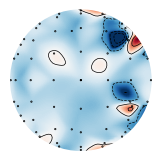

(<matplotlib.image.AxesImage at 0x1d188366d80>,
 <matplotlib.contour.QuadContourSet at 0x1d18834ff20>)

In [15]:
mne.viz.plot_topomap(data, pos, size=1.5)

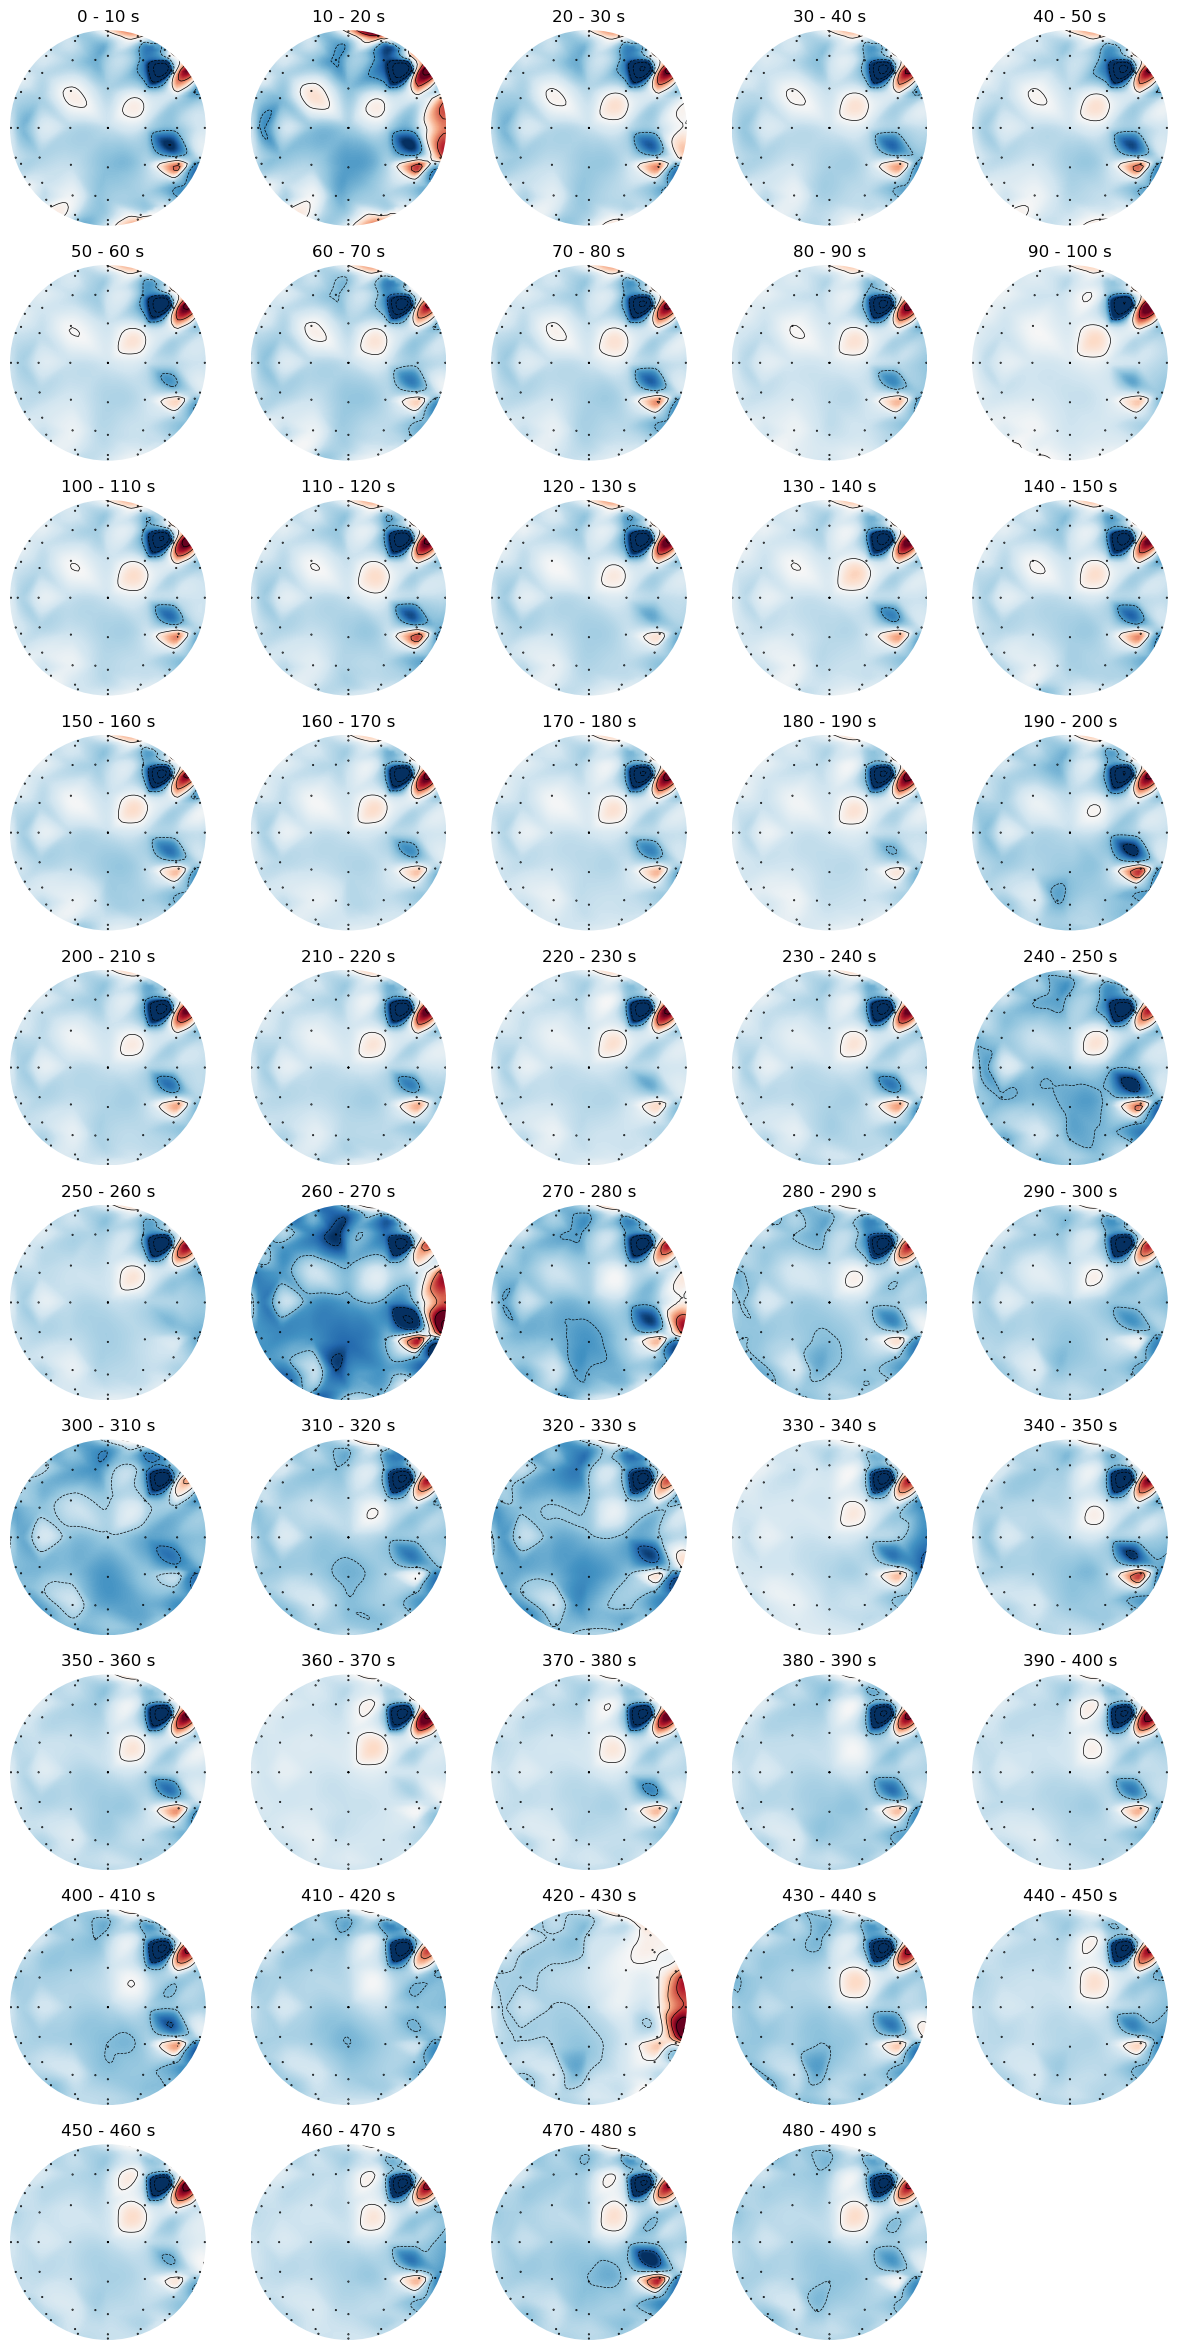

In [16]:
# Plotting every 10 seconds
sfreq = clean_raw.info['sfreq']
n_windows = int(clean_raw.times[-1] // 10)
n_cols = 5
n_rows = (n_windows + n_cols -1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes=axes.flatten()

for i in range(n_windows):
    start_time = i * 10
    end_time = start_time + 10
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)
    data_window = clean_raw.get_data()[:, start_sample:end_sample].mean(axis=1)
    mne.viz.plot_topomap(data_window, pos, show=False, axes=axes[i])
    axes[i].set_title('{} - {} s'.format(start_time, end_time))

# Hide last graph
for j in range(n_windows, n_rows * n_cols): # Basically skipping number of windows out of the total number of axes
    axes[j].axis('off')

plt.savefig('topomap_plot.png', bbox_inches='tight')
plt.show();

In [17]:
raw.compute_psd(picks='eeg')
psd.plot();

Effective window size : 4.096 (s)


NameError: name 'psd' is not defined

In [ ]:
raw.compute_psd(tmax=np.inf, fmax=np.inf).plot(average=True, amplitude=False, picks='data', exclude='bads');

In [ ]:
raw_filt = raw.copy().filter(0.1, 30)
raw_filt.compute_psd(tmax=np.inf, fmax=np.inf).plot(average=True, amplitude=False, picks='data', exclude='bads');

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_filt, ch_name=['FP1', 'FP2'])
eog_epochs.plot_image(combine='mean')

In [ ]:
eog_epochs.average().plot();

In [ ]:
mne.viz.plot_events(eog_epochs.events, event_id=eog_epochs.event_id, sfreq=raw_filt.info['sfreq'])

In [ ]:
# ICA
filt_raw = raw.copy().filter(l_freq=1, h_freq=None)
ica = mne.preprocessing.ICA(n_components=0.99, max_iter='auto', random_state=42)
ica.fit(filt_raw)

In [ ]:
explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

In [ ]:
ica.plot_sources(raw)

In [ ]:
filt_raw = clean_raw.copy().filter(l_freq=1, h_freq=None)
ica = mne.preprocessing.ICA(n_components=0.99, max_iter='auto', random_state=42)
ica.fit(filt_raw)

In [ ]:
ica.plot_components();

In [ ]:
# I suppose that ICA000 and ICA001 refer to heartbeat/blinking artifacts?
# Hence we can exclude them:

ica.exclude = [0, 1]
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(scalings='auto', show_scrollbars=False)
reconst_raw.plot(scalings='auto', show_scrollbars=False)
del reconst_raw

In [ ]:
ica.exclude=[]
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name = ['FP1', 'FP2']);
print(eog_indices)
ica.plot_scores(eog_scores);

In [44]:
from mne.datasets import sample
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity

In [98]:
min_freq = 1.0
max_freq = 50.0
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))
sfreq = raw.info['sfreq']

events = mne.make_fixed_length_events(raw, duration=5.0)
epochs = mne.Epochs(raw, events, tmin=0.0, tmax=2.0, baseline=None)


Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated


In [102]:
con_time = spectral_connectivity_time(epochs, freqs, method='coh', fmin=0.1, fmax=50, sfreq=sfreq, faverage=True)

Replacing existing metadata with 3 columns
Using data from preloaded Raw for 4 events and 1001 original time points ...
only using indices for lower-triangular matrix


ValueError: At least one value in n_cycles corresponds to awavelet longer than the signal. Use less cycles, higher frequencies, or longer epochs.

In [112]:
raw_test = mne.EpochsArray(raw.get_data(), raw.info)

ValueError: Data must be a 3D array of shape (n_epochs, n_channels, n_samples)

In [114]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 67 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 500.0 Hz
>